# Open Data From JSON

In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [3]:
len(df["maintext"])

8492

# Preprocessing 

In [4]:
import re

In [5]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [6]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [7]:
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)

for element in df["tokenized_words"]:
        	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

df["maintext_nouns"] = nouns

In [9]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

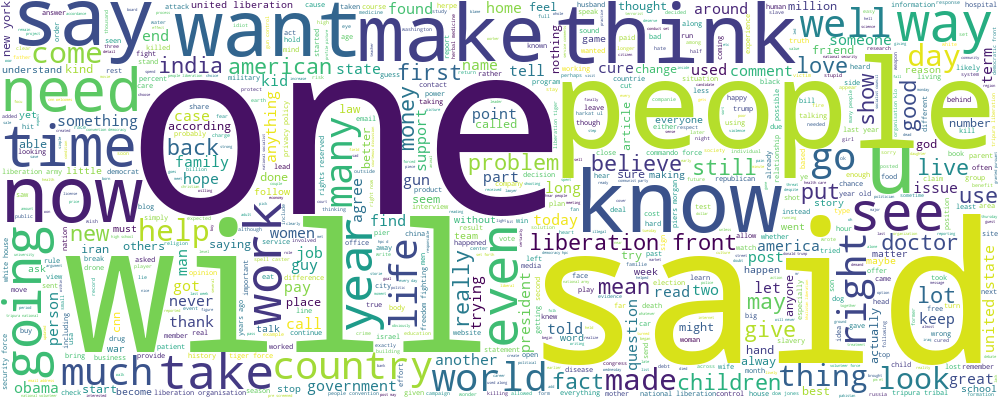

In [11]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

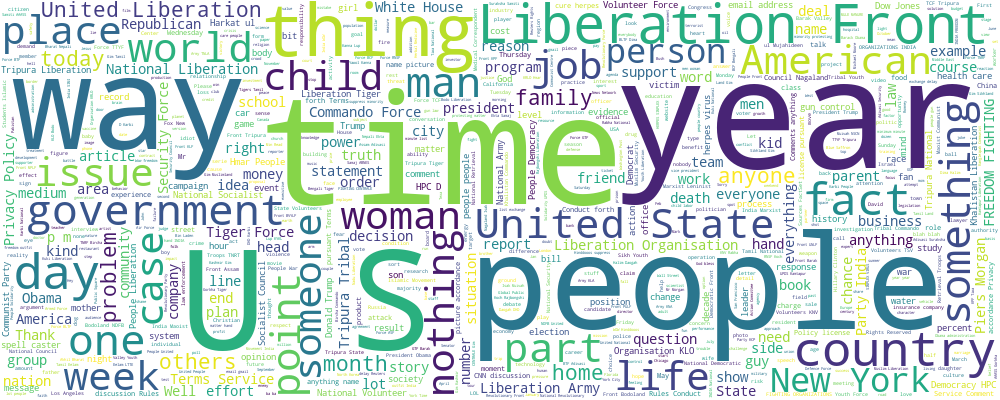

In [12]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

In [13]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
df["maintext_ready"]  = maintext_ready

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
df.head(3)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",2,0.76517,"world, force, child, herpes, family, cnn, doct..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (19, 1), (21, 7), (35, 1), (36, 2), ...",4,0.99987,"liberation, force, tripura, india, national, u..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(10, 4), (15, 1), (19, 1), (21, 7), (22, 1), ...",4,0.64402,"liberation, force, tripura, india, national, u..."


# Wordcloud of the ready-to-cluster articles

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


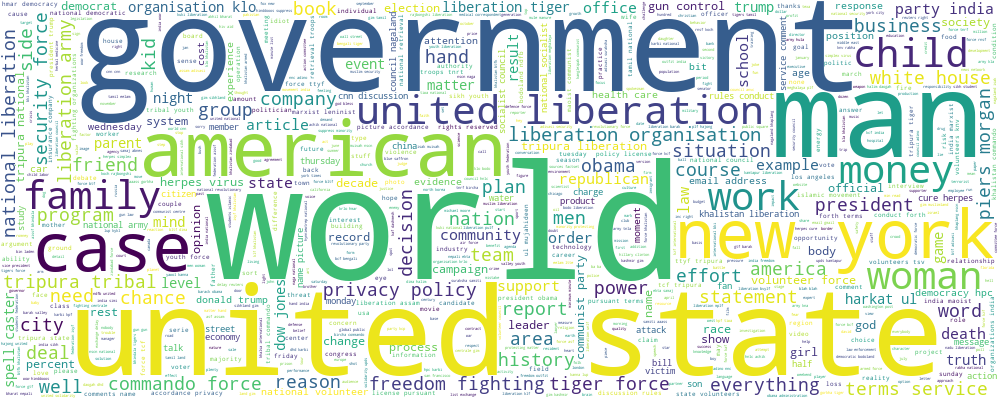

In [113]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

In [114]:
import gensim.corpora as corpora

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
df.head(3)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",2,0.76517,"world, force, child, herpes, family, cnn, doct..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (19, 1), (21, 7), (35, 1), (36, 2), ...",4,0.99987,"liberation, force, tripura, india, national, u..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(10, 4), (15, 1), (19, 1), (21, 7), (22, 1), ...",4,0.64402,"liberation, force, tripura, india, national, u..."


# Build a LDA model (need to find fitting values here)

In [117]:
from pprint import pprint   #pretty printing

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
amount_of_topics = 10  #adjust to find good results

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics)   #build the LDA model

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Displaying the LDA model

In [120]:
pprint(lda_model.print_topics())
articles_lda = lda_model[corpus]

[(0,
  '0.004*"world" + 0.004*"doctor" + 0.004*"force" + 0.004*"child" + '
  '0.004*"cnn" + 0.004*"company" + 0.004*"obama" + 0.003*"president" + '
  '0.003*"woman" + 0.003*"money"'),
 (1,
  '0.005*"gun" + 0.005*"force" + 0.005*"herpes" + 0.004*"liberation" + '
  '0.004*"child" + 0.004*"world" + 0.004*"cure" + 0.003*"man" + 0.003*"cnn" + '
  '0.003*"money"'),
 (2,
  '0.007*"force" + 0.005*"cnn" + 0.005*"tripura" + 0.005*"world" + '
  '0.005*"liberation" + 0.004*"india" + 0.004*"national" + 0.003*"united" + '
  '0.003*"president" + 0.003*"news"'),
 (3,
  '0.008*"force" + 0.007*"liberation" + 0.006*"tripura" + 0.005*"president" + '
  '0.005*"national" + 0.004*"united" + 0.004*"india" + 0.004*"cnn" + '
  '0.003*"state" + 0.003*"world"'),
 (4,
  '0.005*"world" + 0.004*"child" + 0.004*"cnn" + 0.004*"force" + 0.004*"india" '
  '+ 0.003*"president" + 0.003*"woman" + 0.003*"liberation" + 0.003*"school" + '
  '0.003*"america"'),
 (5,
  '0.004*"company" + 0.004*"world" + 0.004*"factset" + 0.004*

# Visualize the LDA model for further analysis (needed to find the best values to adjust)

In [121]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.003950  0.017259       1        1  14.986688
6      0.014267  0.010156       2        1  13.192594
4      0.007193 -0.003318       3        1  12.500382
0      0.007240 -0.001221       4        1  12.350447
8     -0.028686 -0.012073       5        1  11.904901
1     -0.001748  0.006761       6        1  10.401268
5      0.042415 -0.010815       7        1   8.484405
7     -0.014181 -0.000301       8        1   6.589621
2     -0.007920 -0.002745       9        1   5.644079
3     -0.014632 -0.003704      10        1   3.945615, topic_info=            Term          Freq         Total Category  logprob  loglift
361   liberation  17502.000000  17502.000000  Default  30.0000  30.0000
259        force  20504.000000  20504.000000  Default  29.0000  29.0000
508      tripura  13807.000000  13807.000000  Default  28.0000  28.0000
396     national  14857.000000  14857.000000  Default  27.0000  27.0000
3409     factset   2205.000000   2205.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
130        woman    358.197860  11118.316151  Topic10  -6.1434  -0.2027
466      service    315.519598   7461.380754  Topic10  -6.2703   0.0693
746         case    300.982165   6404.116206  Topic10  -6.3174   0.1749
97         right    322.536510   9911.119719  Topic10  -6.2483  -0.1926
715        money    318.555113   9754.885596  Topic10  -6.2607  -0.1892

[901 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
44399      2  0.184962      acua
44399      6  0.554886      acua
142        1  0.106830     adino
142        2  0.046738     adino
142        3  0.086799     adino
...      ...       ...       ...
84190      5  0.118319  zeratsky
84190      7  0.118319  zeratsky
84190      8  0.473275  zeratsky
91463      5  0.595534    zilhao
91463      6  0.198511    zilhao

[3516 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 5, 1, 9, 2, 6, 8, 3, 4])

# Store Cluster IDs to dataframe

In [123]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for i, row in enumerate(articles_lda):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):   #get the dominant topic for each article
            if j == 0:  #dominant topic (only first one)
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_list.append(int(topic_num+1))
                topic_percentage_list.append(round(prop_topic,5))
                topic_keywords_list.append(topic_keywords)
            else: 
                break

df["clusterID"] = topic_list    ##the id of the topic
df["topic_percentage"] = topic_percentage_list  #how well the topic fits
df["topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [124]:
df.head(50)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",10,0.64701,"gun, child, force, world, united, tripura, pie..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(2, 16), (19, 1), (21, 7), (35, 1), (36, 2), ...",9,0.99987,"force, liberation, national, tripura, india, u..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(10, 4), (15, 1), (19, 1), (21, 7), (22, 1), ...",9,0.97058,"force, liberation, national, tripura, india, u..."
3,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 15:53:08",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,3,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(5, 1), (10, 5), (19, 1), (21, 8), (35, 1), (...",9,0.99716,"force, liberation, national, tripura, india, u..."
4,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 17:20:20",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,4,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(4, 1), (18, 1), (19, 2), (21, 19), (27, 6), ...",9,0.99788,"force, liberation, national, tripura, india, u..."
5,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 15:36:52",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,5,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, informa...","[(19, 1), (21, 9), (35, 1), (36, 2), (45, 1), ...",9,0.99716,"force, liberation, national, tripura, india, u..."
6,"06/30/2021, 22:17:27","06/30/2021, 22:1

In [125]:
for cluster_id, data in df.groupby(df.clusterID):
    item = data.topic_keywords.iloc[0].split(",")
    data.to_json(f'./clustered_json/cluster_{cluster_id}-{item[0]}-{item[1]}-{item[2]}.json', orient='records')

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
